In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopy.distance
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from statsmodels.stats.outliers_influence import variance_inflation_factor

# <center>1. Data Exploration and Preprocessing

In [2]:
df = pd.read_csv("uber.csv")

df.drop(['Unnamed: 0','key'], axis = 1, inplace=True)
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [3]:
df = df[df.passenger_count != 0]
df['passenger_count'] = df['passenger_count'].replace([208],2)

In [4]:
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime,utc=True)
df['pickup_timehour']= df['pickup_datetime'].apply(lambda x: x.hour)
df['Day']= df['pickup_datetime'].dt.day_name()
df['Day Part']= pd.cut(df['pickup_timehour'],bins=[-1,4,12,17,21,23],labels=['Night','Morning','Afternoon','Evening','Night'],ordered=False)
df['pickup_month']= df['pickup_datetime'].apply(lambda x: x.month)
df['pickup_year']= df['pickup_datetime'].apply(lambda x: x.year)
df = df[(df.pickup_latitude < 90) & (df.dropoff_latitude < 90) &
        (df.pickup_latitude >- 90) & (df.dropoff_latitude >- 90) &
        (df.pickup_longitude < 180) & (df.dropoff_longitude < 180) &
        (df.pickup_longitude >- 180) & (df.dropoff_longitude >- 180)]
df['Distance'] = [round(geopy.distance.distance((df.pickup_latitude[i], df.pickup_longitude[i]),
                                              (df.dropoff_latitude[i], df.dropoff_longitude[i])).m, 2) 
                                              for i in df.index]

df['Distance'] = df.Distance / 1000

In [5]:
df.isnull().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
pickup_timehour      0
Day                  0
Day Part             0
pickup_month         0
pickup_year          0
Distance             0
dtype: int64

In [6]:
df.dtypes

fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
pickup_timehour                    int64
Day                               object
Day Part                        category
pickup_month                       int64
pickup_year                        int64
Distance                         float64
dtype: object

In [7]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_timehour,Day,Day Part,pickup_month,pickup_year,Distance
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,19,Thursday,Evening,5,2015,1.68111
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,20,Friday,Evening,7,2009,2.45436
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,21,Monday,Evening,8,2009,5.03960
3,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,8,Friday,Morning,6,2009,1.66144
4,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,17,Thursday,Afternoon,8,2014,4.48373


In [8]:
df.shape

(199279, 13)

# <center>2. Exploratory Data Analysis

### Distribution of numeric features 

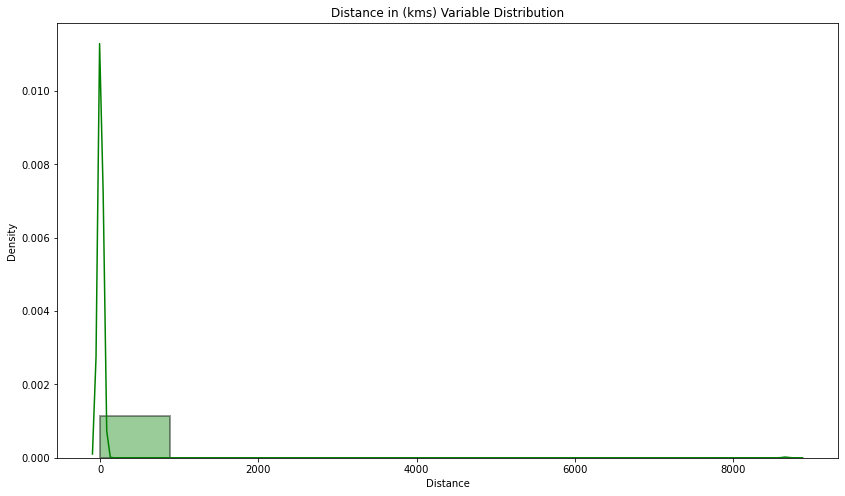

In [9]:
# Distance

plt.figure(figsize = [14,8])
sns.distplot(df['Distance'], color = 'g',hist_kws = dict(edgecolor = "black", linewidth = 2), bins = 10)
plt.title('Distance in (kms) Variable Distribution')
plt.show()

<AxesSubplot:>

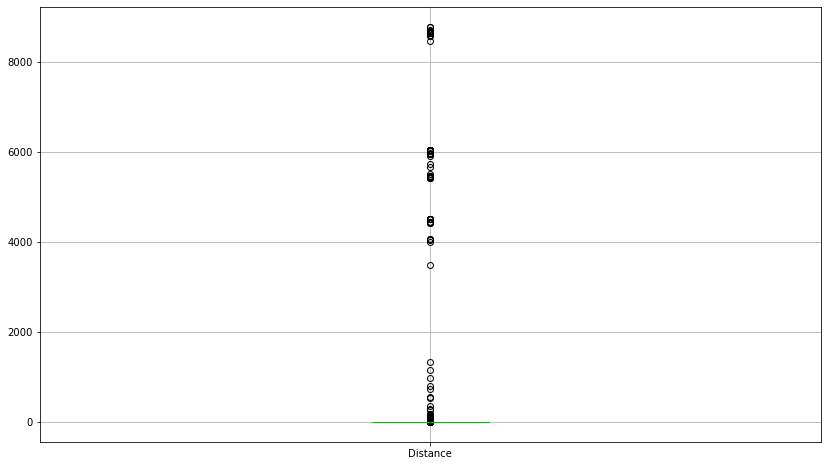

In [10]:
plt.figure(figsize = [14,8])
df.boxplot("Distance")

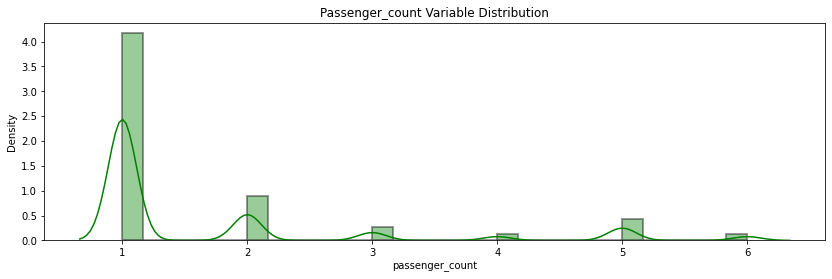

In [11]:
# Passenger count

plt.figure(figsize = [14,4])
sns.distplot(df['passenger_count'], color = 'g',hist_kws=dict(edgecolor = "black", linewidth = 2), bins = 30)
plt.title('Passenger_count Variable Distribution')
plt.show()

<AxesSubplot:>

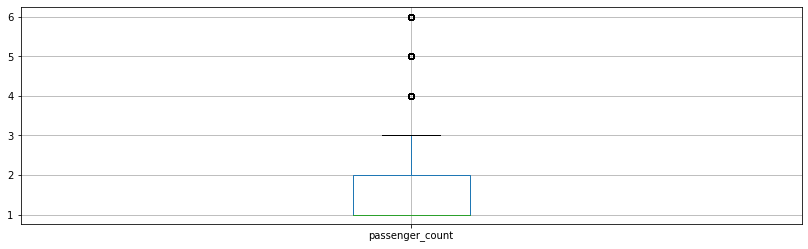

In [12]:
plt.figure(figsize = [14,4])
df.boxplot("passenger_count")

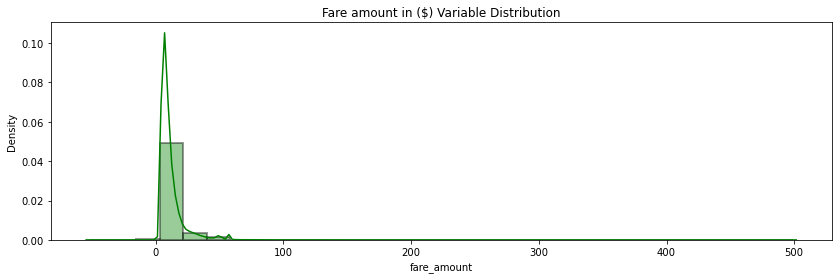

In [13]:
# Fare amount

plt.figure(figsize=[14,4])
sns.distplot(df['fare_amount'], color='g',hist_kws=dict(edgecolor="black", linewidth=2), bins=30)
plt.title('Fare amount in ($) Variable Distribution')
plt.show()

<AxesSubplot:>

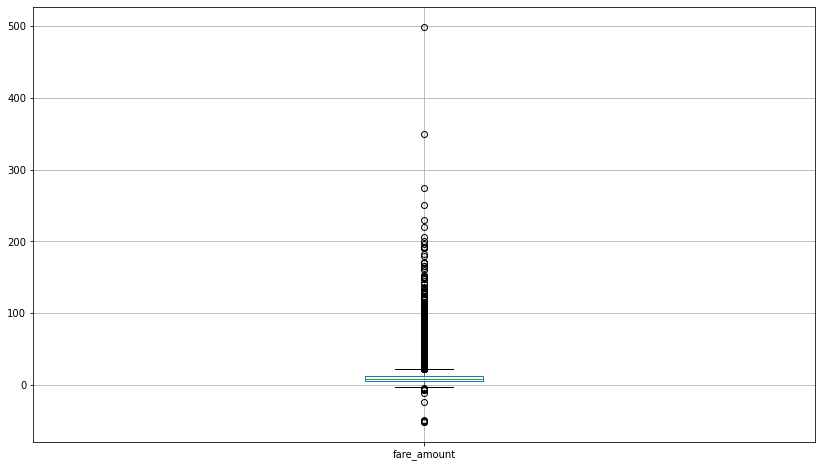

In [14]:
plt.figure(figsize=[14,8])
df.boxplot("fare_amount")

### Distribution of categorical features

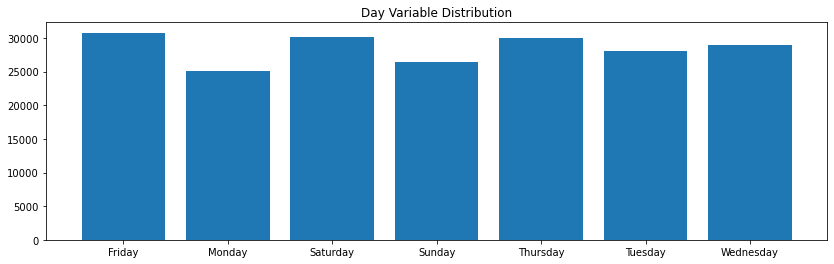

In [15]:
# Day

Day = dict(df.Day.value_counts())
keys = []
values = []
for i in sorted(Day.keys()):
    keys.append(i)
    values.append(Day[i])
    
plt.figure(figsize = [14,4])
plt.bar(keys, values)
plt.title('Day Variable Distribution')
plt.show()

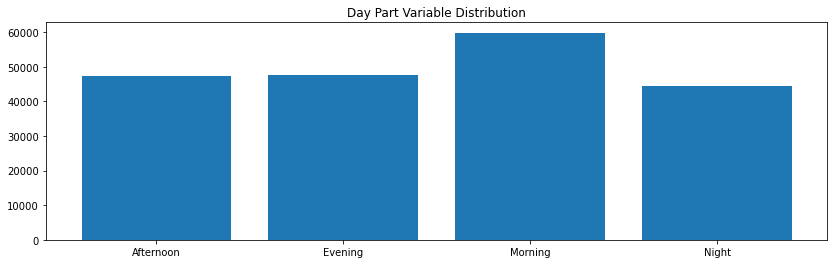

In [16]:
# Day Partly Segment

Day = dict(df['Day Part'].value_counts())
keys = []
values = []
for i in sorted(Day.keys()):
    keys.append(i)
    values.append(Day[i])
    
plt.figure(figsize = [14,4])
plt.bar(keys, values)
plt.title('Day Part Variable Distribution')
plt.show()

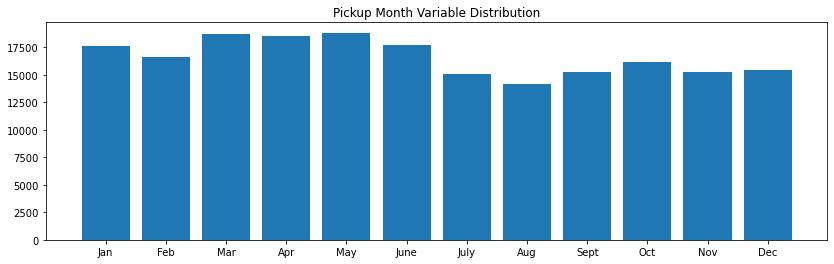

In [17]:
# Monthly quater

month = dict(df.pickup_month.value_counts())
keys = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
values = []
for i in sorted(month.keys()):
#     keys.append(i)
    values.append(month[i])
    
plt.figure(figsize = [14,4])
plt.bar(keys, values)
plt.title('Pickup Month Variable Distribution')
plt.show()

In [18]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_timehour,pickup_month,pickup_year,Distance
count,199279.000000,199279.000000,199279.000000,199279.000000,199279.000000,199279.000000,199279.000000,199279.000000,199279.000000,199279.000000
mean,11.366673,-72.503969,39.919064,-72.513462,39.922967,1.689496,13.492701,6.283141,2011.743837,20.408857
std,9.910671,10.442914,6.128062,10.406258,6.115921,1.305416,6.516217,3.438474,1.859195,377.863594
min,-52.000000,-93.824668,-74.015515,-75.458979,-74.015750,1.000000,0.000000,1.000000,2009.000000,0.000000
25%,6.000000,-73.992063,40.734796,-73.991409,40.733826,1.000000,9.000000,3.000000,2010.000000,1.215640
50%,8.500000,-73.981824,40.752584,-73.980094,40.753042,1.000000,14.000000,6.000000,2012.000000,2.121960
75%,12.500000,-73.967158,40.767155,-73.963662,40.767995,2.000000,19.000000,9.000000,2013.000000,3.875150
max,499.000000,40.808425,48.018760,40.831932,45.031598,6.000000,23.000000,12.000000,2015.000000,8783.593500


### Removing outliers since boxplot showed there existance

In [19]:
outlier_data = df[(df['fare_amount'] <= 0) | (df['passenger_count'] == 0) | (df['pickup_latitude'] == 0.000000)]

In [20]:
# checking the fare amount =0
len(outlier_data[outlier_data['fare_amount'] <= 0])

22

In [21]:
len(outlier_data[(outlier_data['pickup_latitude'] == 0.000000) & (outlier_data['pickup_longitude'] == 0.000000)])

3759

In [22]:
#remove the outliers

df = df[((df['pickup_latitude'] != 0.000000) & (df['pickup_longitude'] != 0.000000))]
df = df[(df['fare_amount'] > 0)]
df = df[(df['passenger_count'] != 0)]

In [23]:
# A threshold for distance <= 50 kms and distannce > 0
df = df[df['Distance'] <= 50]
df = df[df.Distance != 0.00]
df = df[df['fare_amount'] < 300]

In [24]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_timehour,Day,Day Part,pickup_month,pickup_year,Distance
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,19,Thursday,Evening,5,2015,1.68111
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,20,Friday,Evening,7,2009,2.45436
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,21,Monday,Evening,8,2009,5.03960
3,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,8,Friday,Morning,6,2009,1.66144
4,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,17,Thursday,Afternoon,8,2014,4.48373


In [25]:
df.shape

(193165, 13)

# <center>3. Feature selection and Model building

In [26]:
df2 = df.copy()

In [27]:
encoder = LabelEncoder()
df2['Day'] = encoder.fit_transform(df2['Day'])
df2['Day Part'] = encoder.fit_transform(df2['Day Part'])
df2['pickup_year'] = encoder.fit_transform(df2['pickup_year'])

scalar = StandardScaler()
df2['Distance'] =  scalar.fit_transform(df2['Distance'].values.reshape(-1,1))

In [28]:
df2.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_timehour,Day,Day Part,pickup_month,pickup_year,Distance
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,19,4,1,5,6,-0.464303
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,20,0,1,7,0,-0.249505
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,21,1,1,8,0,0.468639
3,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,8,0,2,6,0,-0.469767
4,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,17,4,0,8,5,0.314226


In [29]:
X = df2.iloc[:, 6:].values
y = df2.fare_amount

In [30]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [31]:
regressor1 = LinearRegression()
regressor1.fit(X_train, y_train)

LinearRegression()

In [32]:
print("Training accuracy : ", regressor1.score(X_train, y_train))
print("Test accuracy : ", regressor1.score(X_test, y_test))

Training accuracy :  0.7781398138173318
Test accuracy :  0.7754131912344161


In [33]:
df2.corr()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_timehour,Day,Day Part,pickup_month,pickup_year,Distance
fare_amount,1.000000,0.011832,-0.008636,0.010359,-0.008466,0.012365,-0.020701,-0.002585,0.000952,0.024349,0.121585,0.874936
pickup_longitude,0.011832,1.000000,-0.994005,0.999884,-0.993973,0.009670,0.001840,-0.005300,-0.004546,-0.007511,0.013456,0.005420
pickup_latitude,-0.008636,-0.994005,1.000000,-0.993993,0.999929,-0.009828,-0.000988,0.005617,0.003058,0.008036,-0.014409,-0.002907
dropoff_longitude,0.010359,0.999884,-0.993993,1.000000,-0.993960,0.009665,0.000941,-0.005332,-0.003690,-0.007468,0.013343,0.004505
dropoff_latitude,-0.008466,-0.993973,0.999929,-0.993960,1.000000,-0.009785,-0.001016,0.005605,0.003134,0.007998,-0.014333,-0.002238
passenger_count,0.012365,0.009670,-0.009828,0.009665,-0.009785,1.000000,0.014759,-0.014473,0.003779,0.008785,0.005282,0.008691
pickup_timehour,-0.020701,0.001840,-0.000988,0.000941,-0.001016,0.014759,1.000000,0.021918,-0.372617,-0.004282,0.001936,-0.032262
Day,-0.002585,-0.005300,0.005617,-0.005332,0.005605,-0.014473,0.021918,1.000000,-0.024499,0.000354,-0.004428,-0.010149
Day Part,0.000952,-0.004546,0.003058,-0.003690,0.003134,0.003779,-0.372617,-0.024499,1.000000,0.006800,0.005647,0.043509
pickup_month,0.024349,-0.007511,0.008036,-0.007468,0.007998,0.008785,-0.004282,0.000354,0.006800,1.000000,-0.115294,0.012127


In [34]:
X = df2[['pickup_year', 'Distance']].values
y = df2.fare_amount

In [35]:
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.3,random_state=10)

In [36]:
regressor2 = LinearRegression()
regressor2.fit(X_train, y_train)

LinearRegression()

In [37]:
print("Training accuracy : ", regressor2.score(X_train, y_train))
print("Test accuracy : ", regressor2.score(X_test, y_test))

Training accuracy :  0.7759081737835758
Test accuracy :  0.7733947003847169


## From the above model's performance and the correlation data we can see that the model can perform even better with better feature selection. In model1 we took all the features and in model2 we took features with high correlation but both performance are the same. And when we observe there is some multicollinarity and we'll work on that further

### Let's drop some unmeaningful columns 

In [38]:
df.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'pickup_timehour', 'Day', 'Day Part', 'pickup_month', 'pickup_year',
       'Distance'],
      dtype='object')

In [39]:
df.drop(['pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'pickup_timehour'], axis = 1, inplace = True)

### OneHotEncoding the Day and Day Part to get features

In [40]:
df_temp= pd.get_dummies(df[['Day','Day Part']], drop_first = True)
df = pd.concat([df, df_temp], axis = 1)

In [41]:
df.drop(['Day', 'Day Part'], axis = 1, inplace = True)

In [42]:
df.head()

,fare_amount,passenger_count,pickup_month,pickup_year,Distance,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday,Day Part_Evening,Day Part_Morning,Day Part_Night
0,7.5,1,5,2015,1.68111,0,0,0,1,0,0,1,0,0
1,7.7,1,7,2009,2.45436,0,0,0,0,0,0,1,0,0
2,12.9,1,8,2009,5.03960,1,0,0,0,0,0,1,0,0
3,5.3,3,6,2009,1.66144,0,0,0,0,0,0,0,1,0
4,16.0,5,8,2014,4.48373,0,0,0,1,0,0,0,0,0


In [43]:
df.shape

(193165, 14)

## Checking for Multicollinearity using Variance Inflation Factor (Higher VIF means existance of Multicollinearity)

In [44]:
# VIF

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [45]:
X = df.iloc[:, 1:]
calc_vif(X)

,variables,VIF
0,passenger_count,2.684166
1,pickup_month,4.336003
2,pickup_year,15.492259
3,Distance,1.877357
4,Day_Monday,1.819632
5,Day_Saturday,1.991187
6,Day_Sunday,1.868571
7,Day_Thursday,1.974273
8,Day_Tuesday,1.915341
9,Day_Wednesday,1.942511


In [46]:
# Removing those features with high VIF
df.drop(['pickup_year', 'pickup_month'], axis = 1, inplace = True)

In [47]:
X = df.iloc[:, 1:]
calc_vif(X)

,variables,VIF
0,passenger_count,2.323053
1,Distance,1.757002
2,Day_Monday,1.373741
3,Day_Saturday,1.477487
4,Day_Sunday,1.420841
5,Day_Thursday,1.456978
6,Day_Tuesday,1.417900
7,Day_Wednesday,1.432193
8,Day Part_Evening,1.656361
9,Day Part_Morning,1.806143


## Training 

In [48]:
scaler = MinMaxScaler()

In [49]:
X = df.iloc[:, 1:]
y = df.fare_amount

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)
X_train['Distance'] = scaler.fit_transform(X_train['Distance'].values.reshape(-1, 1))
X_test['Distance'] = scaler.transform(X_test['Distance'].values.reshape(-1, 1))

In [51]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [52]:
print("Training accuracy : ", regressor.score(X_train, y_train))
print("Test accuracy : ", regressor.score(X_test, y_test))

Training accuracy :  0.7695080757998611
Test accuracy :  0.7661039279013575


### The simple linear model performed with a decent score. Let us try with a complex model

## Random Forest Regression Model

In [53]:
rf_regressor = RandomForestRegressor(n_estimators = 10)
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10)

In [54]:
print("Training accuracy : ", rf_regressor.score(X_train, y_train))
print("Test accuracy : ", rf_regressor.score(X_test, y_test))

Training accuracy :  0.9523057892267294
Test accuracy :  0.7269304090681907


# <center>4. Model Optimization

In [55]:
# Using Random Search and Grid model let's find the best parameter for our regression model

rf_reg = RandomForestRegressor()
parameters = {'n_estimators':[i for i in range(30,50,5)], 'max_depth':[i for i in range(2,20,5)],
              'min_samples_split':[3,4,5,7,10,20], 'min_samples_leaf':[10,20,30,40,50]}
n_folds = 5
grid_model = RandomizedSearchCV(estimator=rf_reg, param_distributions=parameters, cv=n_folds, scoring='r2',
                                return_train_score=True)
grid_model.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                   param_distributions={'max_depth': [2, 7, 12, 17],
                                        'min_samples_leaf': [10, 20, 30, 40,
                                                             50],
                                        'min_samples_split': [3, 4, 5, 7, 10,
                                                              20],
                                        'n_estimators': [30, 35, 40, 45]},
                   return_train_score=True, scoring='r2')

In [56]:
grid_model.best_params_

{'n_estimators': 40,
 'min_samples_split': 20,
 'min_samples_leaf': 30,
 'max_depth': 12}

In [57]:
grid_model.best_score_

0.7862873200111796

In [58]:
opt_rf_regressor = RandomForestRegressor(n_estimators = 40, max_depth=12, min_samples_split = 10, min_samples_leaf = 10)
opt_rf_regressor.fit(X_train, y_train)

RandomForestRegressor(max_depth=12, min_samples_leaf=10, min_samples_split=10,
                      n_estimators=40)

In [59]:
print("Training accuracy : ", opt_rf_regressor.score(X_train, y_train))
print("Test accuracy : ", opt_rf_regressor.score(X_test, y_test))

Training accuracy :  0.8127552243904019
Test accuracy :  0.7882452423934252


## The above model seems to perform well with an accuracy of 80% 

## Thank you 